Kaggle dataset: https://www.kaggle.com/code/jatingoyal123/hate-offensive-language

In [35]:
import pandas as pd
import matplotlib as plt

In [68]:
pd.read_csv('./data/labeled_data.csv').head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


First we clean the dataframe by removing the unnecessary columns that map to 'class' column which tells us what type the tweet is. We also get rid of the redundant id column.

In [86]:
# Read csv file
df_tweets = pd.read_csv('./data/labeled_data.csv')

# Create a dictionary to map the labels to numbers
label_dict = {'hate_speech': 0, 'offensive_language': 1, 'neither': 2}

# Drop the columns we don't need
df_tweets = df_tweets.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

# Rename the columns
df_tweets = df_tweets.rename(columns={'tweet': 'text', 'class.1': 'label'})

print(f"Shape of the dataframe: {df_tweets.shape}")

Shape of the dataframe: (24783, 2)


[Text(0, 0, 'Hate speech'),
 Text(1, 0, 'Offensive language'),
 Text(2, 0, 'Neither')]

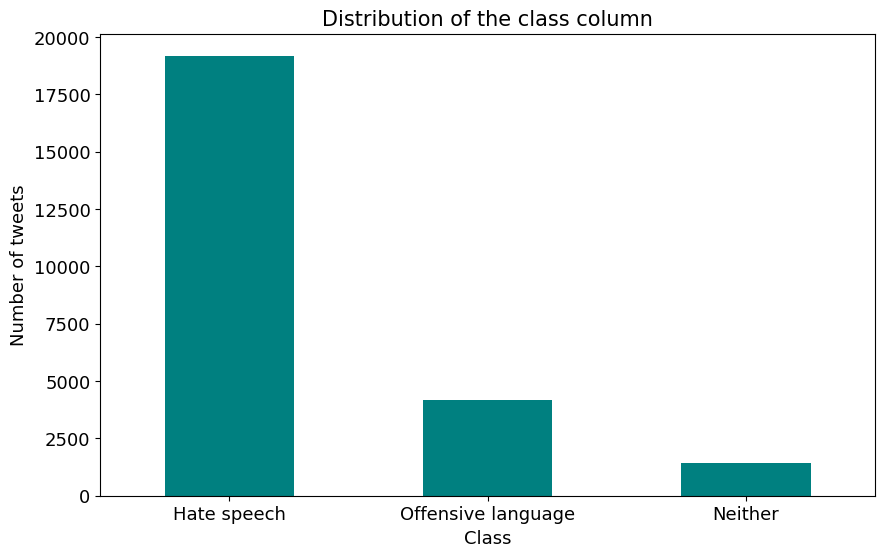

In [89]:
# Plot the distribution of the class column
ax = df_tweets['class'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='teal')

# Add the title and labels
ax.set_title('Distribution of the class column', fontsize=15)
ax.set_ylabel('Number of tweets', fontsize=13)
ax.set_xlabel('Class', fontsize=13)

# Set the xticts with the class names
ax.set_xticklabels(['Hate speech', 'Offensive language', 'Neither'], rotation=0)
